## Ablation Analysis

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import tqdm

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import create_random_mask
import sklearn
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
tardis.config = tardis.config_server

In [3]:
torch.cuda.is_available()

False

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
# ablation_adata_path = os.path.join(tardis.config.io_directories['processed'], "figures", "ablation_afriat.h5ad")
ablation_data_path = os.path.join(tardis.config.io_directories['processed'], "figures",  "ablation_afriat.pickle")

In [7]:
# Load the data from the pickle file
with open(ablation_data_path, 'rb') as file:
    data_loaded = pickle.load(file)

# Access your data
n_leiden_df = data_loaded['n_leiden_df']
latent_dict = data_loaded['latent_dict']
reconst_r2_all = data_loaded['reconst_r2_all']
reconst_r2_valid = data_loaded['reconst_r2_valid']
mi_normalized = data_loaded['mi_normalized']
max_mig_all = data_loaded['max_mig_all']
max_mig_valid = data_loaded['max_mig_valid']

# adata = ad.read_h5ad(ablation_adata_path)

In [8]:
max_mig_valid

{0.0: 0.8585715198922256,
 0.2: 0.8587961149850664,
 0.3: 0.867165804485262,
 0.4: 0.8261072910194294,
 0.5: 0.8488363532396533,
 0.6: 0.8353567122979633,
 0.7: 0.8536242671950222,
 0.8: 0.8210183243226968,
 0.9: 0.8539627423712751,
 0.91: 0.8275202520148476,
 0.92: 0.8285614242025471,
 0.93: 0.8519926315584619,
 0.94: 0.7773606707512649,
 0.95: 0.6709760056150155,
 0.96: 0.7437340479226687,
 0.97: 0.6901277445897412,
 0.98: 0.7660394787282927,
 0.99: 0.7401283890791187,
 0.991: 0.804180330111771,
 0.992: 0.8046719909541874,
 0.993: 0.7860329968362411,
 0.994: 0.8173365830246252,
 0.995: 0.6922811720646583,
 0.996: 0.7490353943927426,
 0.997: 0.7278645601053144,
 0.998: 0.4640791582955388,
 0.999: 0.46197061956663393}

In [11]:
reconst_r2_valid

{'scvi': 0.9769290031595553,
 0.0: 0.9766822716081428,
 0.2: 0.9761572867304296,
 0.3: 0.9747354378116343,
 0.4: 0.9745455959080092,
 0.5: 0.9751078761983187,
 0.6: 0.9773025591267898,
 0.7: 0.9761455348042299,
 0.8: 0.9716910089573945,
 0.9: 0.9764363995273785,
 0.91: 0.9805905392074862,
 0.92: 0.9738826884086313,
 0.93: 0.9517783758350072,
 0.94: 0.9775993097078459,
 0.95: 0.9723433831758708,
 0.96: 0.9575226193229798,
 0.97: 0.981189553569384,
 0.98: 0.9433826109284407,
 0.99: 0.962277699943854,
 0.991: 0.9341158064182934,
 0.992: 0.8450009507649952,
 0.993: 0.975685613705338,
 0.994: 0.9694933528870008,
 0.995: 0.9760807429086132,
 0.996: 0.9802743857637388,
 0.997: 0.9439044456221788,
 0.998: 0.9750436776901321,
 0.999: 0.8641569842299212}

In [92]:
rows = []
for k, v in reconst_r2_valid.items():
    if k=="scvi":
        continue
    rows.append({"Percent Removed Feature": float(k), r"R$^2$ Reconstruction": v})
df = pd.DataFrame(rows)

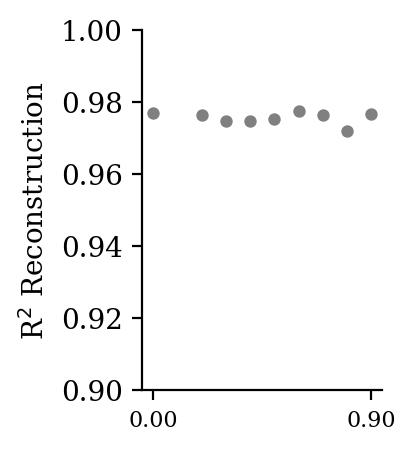

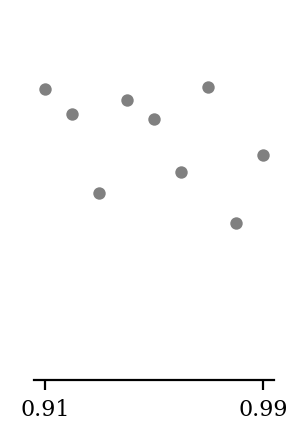

In [93]:
figsize = (2, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)

x=df["Percent Removed Feature"].to_numpy().flatten()[:-18]
y=df[r"R$^2$ Reconstruction"].to_numpy().flatten()[:-18]
sns.scatterplot(x=x, y=y, s=20, color="gray", linewidth=0)
plt.xlabel("")
plt.ylabel(r"R$^2$ Reconstruction")
plt.xticks([x[0], x[-1]], [f'{x[0]:.2f}', f'{x[-1]:.2f}'], fontsize=8)
plt.ylim(0.9, 1)
sns.despine()

plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", f"fig2_ablation_r2.pdf"), format="pdf")

figsize = (2, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)

x=df["Percent Removed Feature"].to_numpy().flatten()[-18:-9]
y=df[r"R$^2$ Reconstruction"].to_numpy().flatten()[-18:-9]
sns.scatterplot(x=x, y=y, s=20, color="gray", linewidth=0)
plt.xlabel("")
plt.ylabel(r"R$^2$ Reconstruction")
plt.xticks([x[0], x[-1]], [f'{x[0]:.2f}', f'{x[-1]:.2f}'], fontsize=8)
plt.ylim(0.9, 1)
plt.ylabel("")
plt.gca().set_yticks([])
sns.despine(left=True)

plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", f"fig2_ablation_r2_2.pdf"), format="pdf")

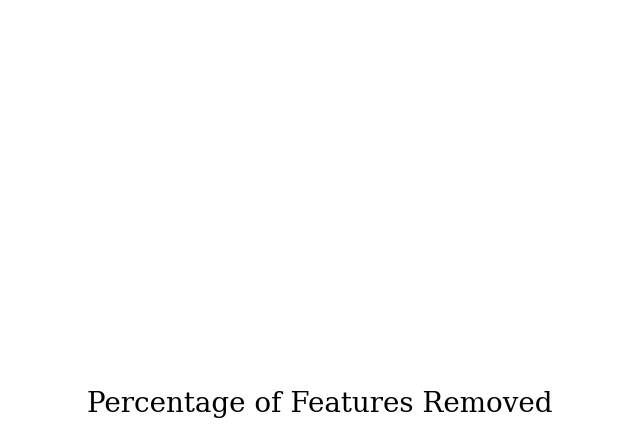

In [94]:
figsize = (5, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)

x=df["Percent Removed Feature"].to_numpy().flatten()[-18:-9]
y=df[r"R$^2$ Reconstruction"].to_numpy().flatten()[-18:-9]
sns.scatterplot(x=x, y=y, s=20, color="gray", linewidth=0)
plt.xlabel("Percentage of Features Removed")
plt.ylabel(r"R$^2$ Reconstruction")
plt.xticks([x[0], x[-1]], [f'{x[0]:.2f}', f'{x[-1]:.2f}'], fontsize=8)
plt.ylim(2, 3)
plt.ylabel("")
plt.gca().set_yticks([])
plt.gca().set_xticks([])
sns.despine(left=True, bottom=True)

plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", f"fig2_ablation_r2_xlabel.pdf"), format="pdf")

In [95]:
rows = []
for k, v in max_mig_valid.items():
    if k=="scvi":
        continue
    rows.append({"Percent Removed Feature": float(k), "maxMIG": v})
df = pd.DataFrame(rows)

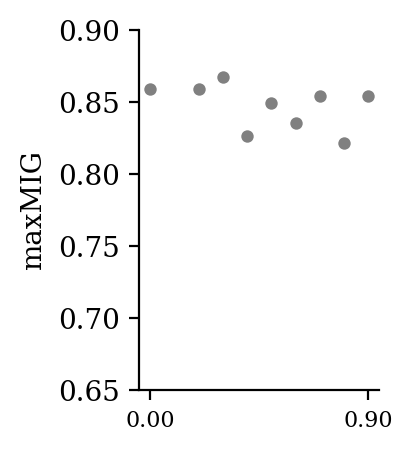

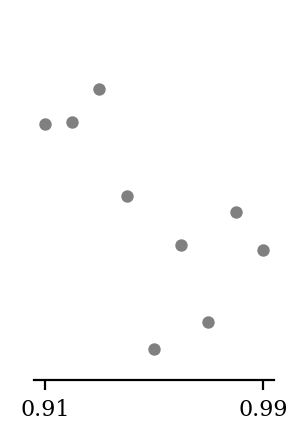

In [96]:
figsize = (2, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)

x=df["Percent Removed Feature"].to_numpy().flatten()[:-18]
y=df["maxMIG"].to_numpy().flatten()[:-18]
sns.scatterplot(x=x, y=y, s=20, color="gray", linewidth=0)
plt.xlabel("")
plt.ylabel("maxMIG")
plt.xticks([x[0], x[-1]], [f'{x[0]:.2f}', f'{x[-1]:.2f}'], fontsize=8)
plt.ylim(0.65, 0.9)
sns.despine()

plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", f"fig2_ablation_maxMIG.pdf"), format="pdf")

figsize = (2, 3)
fig = plt.figure(figsize=(figsize[0] * 3, figsize[1] * 3))
fig.subplots_adjust(left=0.4, right=0.6, top=0.6, bottom=0.4)

x=df["Percent Removed Feature"].to_numpy().flatten()[-18:-9]
y=df["maxMIG"].to_numpy().flatten()[-18:-9]
sns.scatterplot(x=x, y=y, s=20, color="gray", linewidth=0)
plt.xlabel("")
plt.ylabel("maxMIG")
plt.xticks([x[0], x[-1]], [f'{x[0]:.2f}', f'{x[-1]:.2f}'], fontsize=8)
plt.ylim(0.65, 0.9)
plt.ylabel("")
plt.gca().set_yticks([])
sns.despine(left=True)

plt.savefig(os.path.join("/home/icb/kemal.inecik/work/codes/tardis/training/server/figures", f"fig2_ablation_maxMIG_2.pdf"), format="pdf")

In [97]:
latent_dict[0.0].shape

(19053, 48)

In [ ]:
# a metric to calculate the number of clusters e.g. it should be 3 in sample status etc.
# aws? knn etc?